# Advantage Actor-Critic A2C

Здесь рассмотрим основные идеи алгоритма, приведем псевдокод и его реализацию на Python.

Actor-Critic это смешанный подход, включающий обновление V-функции и обновление политики.

В этом алгоритме агент одновременно обучает две сети. Одну для политики, она используется для предсказания действия на каждом шаге и вторую для аппроксимации V-функции на следующем шаге.

## Реализация:
1. Инициализируем случайным образом сети политики (actor) $\pi^{\mu}(a|s)|_{\theta^{\mu}}$ и V-функции (critic) $V^{\theta}(s)|_{\theta^{V}}$ с весами $\theta^V$ и $\theta^{\mu}$ и целевые сети $V'$ и $\pi'$: $\theta^{V'} \gets \theta^V$ и $\theta^{\mu'} \gets \theta^{\mu}$
2. Устанавливаем число эпизодов обучения $M$ и для каждого эпизода выполняем:
3. Проходим траекторию, пока не достигнем конечного состояния.
    - Находясь в состоянии $s_t$ действуем в силу текущей политики и выбираем действие $a_t = \pi^{\mu}(s_t)|_{\theta^{\mu}}$
    - Выполняем действие $a_t$ и переходим в состояние $s_{t+1}$ и получаем награду $r_t$
    - В состоянии $s_{t+1}$ действуя в силу текущей политики выбираем действие $a_{t+1} = \pi^{\mu}(s_{t+1})|_{\theta^{\mu}}$
    - Вычисляем $Loss(\theta^V)=\big( r_t + \gamma V^{\theta}(s_{t+1}) - V^{\theta}(s_t) \big)^2$
    - Вычисляем $Loss(\theta^{\mu}) = \ln{\pi^{\mu}(a_t|s_t)}(r_t + \gamma V^{\theta}(s_{t+1}) - V^{\theta}(s_t))$
    - Обновляем веса: </br>
    __Внимание!__ У V-функции мы ___минимизируем___ веса, а в политике ___максимизируем_!__ </br>
      $\quad \quad \theta^V \gets \theta^V - \alpha \nabla_{\theta^V}Loss(\theta^V)$, </br>
      $\quad \quad \theta^{\mu} \gets \theta^{\mu} + \beta \nabla_{\theta^{\mu}}Loss(\theta^{\mu})$ 
    - Обновляем целевые сети: </br>
    $\quad \quad \theta^{V'} \gets \tau \theta^V + (1 - \tau) \theta^{V'}$, </br>
    $\quad \quad \theta^{\mu'} \gets \tau \theta^{\mu} + (1 - \tau) \theta^{\mu'}$

# Imports

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

import matplotlib.pyplot as plt

In [2]:
gym.__version__

'0.29.0'

# Actor & Value Nets

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ActorNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.output = nn.Linear(hidden_dim, 2)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        logits = self.output(outs)
        return logits

class ValueNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        value = self.output(outs)
        return value

actor_func = ActorNet().to(device)
value_func = ValueNet().to(device)

In [4]:
# Получить действие на основе текущей политики
def pick_sample(s):
    with torch.no_grad():
        #   --> size : (1, 4)
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
        # Get logits from state
        #   --> size : (1, 2)
        logits = actor_func(s_batch)
        #   --> size : (2)
        logits = logits.squeeze(dim=0)
        # From logits to probabilities
        probs = F.softmax(logits, dim=-1)
        # Pick up action's sample
        a = torch.multinomial(probs, num_samples=1)
        # Return
        return a.tolist()[0]

# Main loop

In [7]:
gamma = 0.99  # дисконтирование
env = gym.make("CartPole-v1")  # среда
reward_records = []  # массив наград

# Оптимизаторы
opt1 = torch.optim.AdamW(value_func.parameters(), lr=0.001) 
opt2 = torch.optim.AdamW(actor_func.parameters(), lr=0.001)

# количество циклов обучения
num_episodes = 1500
# 
for i in range(num_episodes):
    # в начале эпизода обнуляем массивы и сбрасываем среду
    done = False
    states = [] 
    actions = []
    rewards = []
    s, _ = env.reset()

    # пока не достигнем конечного состояния продолжаем выполнять действия
    while not done:
        # добавить состояние в список состояний
        states.append(s.tolist())
        # по текущей политике получить действие
        a = pick_sample(s)
        # выполнить шаг, получить награду (r), следующее состояние (s) и флаги конечного состояния (term, trunc)
        s, r, term, trunc, _ = env.step(a)
        # если конечное состояние - устанавливаем флаг окончания в True
        done = term or trunc
        # добавляем действие и награду в соответствующие массивы
        actions.append(a)
        rewards.append(r)

    #
    # Если траектория закончилась (достигли финального состояния)
    #
    # формируем массив полной награды для каждого состояния
    cum_rewards = np.zeros_like(rewards)
    reward_len = len(rewards)
    for j in reversed(range(reward_len)):
        cum_rewards[j] = rewards[j] + (cum_rewards[j+1]*gamma if j+1 < reward_len else 0)

    #
    # Оптимизируем параметры сетей
    #

    # Оптимизируем value loss (Critic)
    # Обнуляем градиенты в оптимизаторе
    opt1.zero_grad()
    # преобразуем состояния и суммарные награды для каждого состояния в тензор
    states = torch.tensor(states, dtype=torch.float).to(device)
    cum_rewards = torch.tensor(cum_rewards, dtype=torch.float).to(device)

    # Вычисляем лосс
    values = value_func(states)
    values = values.squeeze(dim=1)
    vf_loss = F.mse_loss(
        values,
        cum_rewards,
        reduction="none")
    # считаем градиенты
    vf_loss.sum().backward()
    # делаем шаг оптимизатора
    opt1.step()

    # Оптимизируем policy loss (Actor)
    with torch.no_grad():
        values = value_func(states)

    # Обнуляем градиенты
    opt2.zero_grad()
    # преобразуем к тензорам
    actions = torch.tensor(actions, dtype=torch.int64).to(device)
    # считаем advantage функцию
    advantages = cum_rewards - values

    # считаем лосс
    logits = actor_func(states)
    log_probs = -F.cross_entropy(logits, actions, reduction="none")
    pi_loss = -log_probs * advantages
    
    # считаем градиент
    pi_loss.sum().backward()
    # делаем шаг оптимизатора
    opt2.step()

    # Выводим итоговую награду в эпизоде (max 500)    
    reward_records.append(sum(rewards))

    if i % 100 == 0:
        print("Run episode {} with average reward {}".format(i, np.mean(reward_records[-100:])), end="\r")

    # stop if mean reward for 100 episodes > 475.0
    if np.average(reward_records[-100:]) > 475.0:
        break

print("\nDone")
env.close()

Run episode 1300 with average reward 467.35
Done


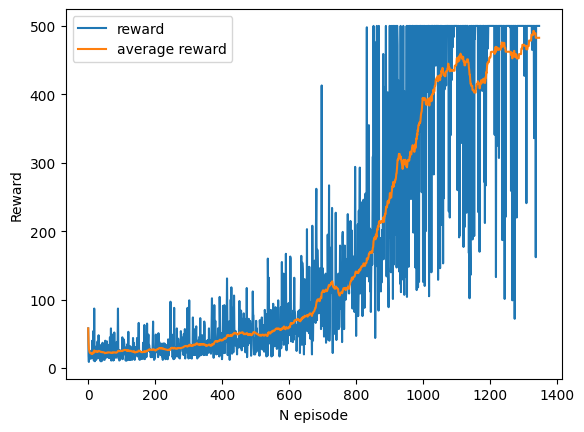

In [8]:
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))

# Plot
plt.plot(reward_records, label='reward')
plt.plot(average_reward, label='average reward')
plt.xlabel('N episode')
plt.ylabel('Reward')
plt.legend()
plt.show();